# 05 - Generating Chemistries using VAE

## 1.0 Importing libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [3]:
import pickle
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate, KFold

In [5]:
import itertools

In [22]:
from ray import tune
from ray.air import Checkpoint, sessionpp 
from ray.tune.schedulers import ASHAScheduler

ImportError: cannot import name 'Checkpoint' from 'ray.air' (/Users/chinmayasukumar/opt/anaconda3/lib/python3.9/site-packages/ray/air/__init__.py)

### 2.1 Creating Training sets

## 1.1 Importing data

In [6]:
path = '/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-2b_Generating_steel_chemistries/data/raw/steel_clean_final.csv'
data = pd.read_csv(path)

In [7]:
data.head()

,c,si,mn,p,s,ni,cr,mo,cu,v,al,n,nb+ta,temp,yield
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,27,342
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,100,338
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,200,337
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,300,346
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,400,316


In [8]:
# Features for X
X = data.iloc[:,:14]

# Target is yield strength
y = data.iloc[:,14]

# SPlitting to train and test & validation sets
X_train, X_test_val, _,  y_test_val = train_test_split(X, y, test_size=0.3, random_state=123)

# Splitting to test and validation sets
X_test, X_val, y_test, _ = train_test_split(X_test_val, y_test_val, test_size=0.4, random_state=123)

In [9]:
# Verifying the shapes of the train and test sets
X_train.shape, X_test.shape, X_val.shape

((432, 14), (111, 14), (75, 14))

## 2.0 Model creation

### 2.1 Creating Training sets

In [11]:
# Modify the data loading
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) # creating datset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### 2.2 Creating VAE Class

In [12]:
def train_vae(model, train_loader, num_epochs, lr):

    # Define the optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            input_data = data[0]  # Assuming the input data is the first element in the batch
            target_data = data[0]  # Assuming the target data is the second element in the batch
            input_data = torch.tensor(input_data, dtype=torch.float32)
            target_data = torch.tensor(target_data, dtype=torch.float32)
            recon_batch, mu, logvar = model(input_data)
            loss = criterion(recon_batch, target_data) + 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Append the average loss for the epoch to the train_losses list
        train_losses.append(train_loss / len(train_loader))
        
    
        # print('Epoch: {}, Loss: {:.6f}'.format(epoch+1, train_loss / len(train_loader)))

    return train_losses


### 2.3 Creating Evaluation Function

In [13]:
# Evaluating VAE

def evaluate_vae(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(data_loader):
            input_data = data[0]
            target_data = data[0]
            input_data = torch.tensor(input_data, dtype=torch.float32)
            target_data = torch.tensor(target_data, dtype=torch.float32)
            recon_batch, _, _ = model(input_data)
            loss = criterion(recon_batch, target_data)
            total_loss += loss.item() * input_data.size(0)
            num_samples += input_data.size(0)

    average_loss = total_loss / num_samples
    return average_loss

## 3.0 Model Training & Selection

### 3.1 Hyperparameter tuning

In [14]:
# Creating validation sets
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor) 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

### 3.2 Grid Search

In [16]:
param_grid = {'batch_size': [32, 64, 128], 'lr': [0.001, 0.01, 0.05,  0.1], 'latent_dim': [2, 4, 8, 10, 12], 'n_nodes': [16, 32, 64]}

grid = RandomizedSearchCV(VAE, param_distributions=param_grid, n_iter=10, cv=3, random_state=123, verbose=2, n_jobs=-1)

In [17]:
grid.fit(X_train_tensor, X_train_tensor)

TypeError: estimator should be an estimator implementing 'fit' method, <class '__main__.VAE'> was passed

In [15]:
learning_rates = [0.001, 0.005]
n_nodes = [16, 32, 64]
latent_dims = [5, 10, 20, 30]

best_loss = float('inf')
best_hyperparameters = {}
losses = {'lr':[], 'n_nodes':[], 'latent_dims':[], 'train_loss':[], 'val_loss':[]}

for lr, nodes, latent_dim in itertools.product(learning_rates, n_nodes, latent_dims):
    model = VAE(latent_dim=latent_dim, n_nodes=nodes)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = train_vae(model, train_loader, 150, lr)
    val_loss = evaluate_vae(model, val_loader, criterion)

    losses['train_loss'].append(train_losses)
    losses['val_loss'].append(val_loss)
    losses['lr'].append(lr)
    losses['n_nodes'].append(nodes)
    losses['latent_dims'].append(latent_dim)

    if val_loss < best_loss:
        best_loss = val_loss
        best_hyperparameters = {'lr': lr, 'n_nodes': nodes, 'latent_dims': latent_dim}
        best_model = model.state_dict()

best_model_path = '/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-2b_Generating_steel_chemistries/models/best_vae.pth'
torch.save({'hyperparameters': best_hyperparameters, 'model_state_dict': best_model}, best_model_path)


/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_70230/931870296.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype=torch.float32)
/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_70230/931870296.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_data = torch.tensor(target_data, dtype=torch.float32)
/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_70230/87308926.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dty

KeyboardInterrupt: 

In [20]:
losses_df = pd.DataFrame(losses)

In [21]:
losses_df.sort_values(by='val_loss', ascending=True)

,lr,n_nodes,latent_dims,train_loss,val_loss
23,0.005,64,30,"[1068806384273.4286, 94376674.85714285, 166046...",16.616360
13,0.005,16,10,"[6763.48601422991, 6123.44287109375, 5942.0514...",18.606594
17,0.005,32,10,"[2119033568.890904, 6346.346784319197, 6143.13...",20.049708
15,0.005,16,30,"[80513.78867885044, 6638.915422712053, 6240.16...",25.299865
18,0.005,32,20,"[23618186806.1596, 22193.789620535714, 7180.95...",26.267933
14,0.005,16,20,"[321660490.50558037, 69060.85309709821, 15310....",27.717617
20,0.005,64,5,"[145755437.91524833, 12564.15966796875, 7404.4...",29.751145
22,0.005,64,20,"[99748559905.25781, 65763.44761439732, 8743.03...",39.549047
12,0.005,16,5,"[1015636548.2009975, 6385.760166713169, 6249.9...",40.633386
8,0.001,64,5,"[9005.272705078125, 6868.837995256697, 6435.00...",47.572509


In [22]:
print(best_hyperparameters)

{'lr': 0.005, 'n_nodes': 64, 'latent_dims': 30}


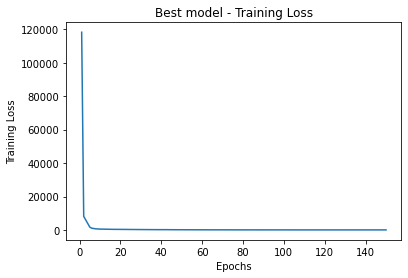

In [17]:
best_model_loss = losses_df['val_loss'].min()

best_model_train_loss = losses_df[losses_df['val_loss'] == best_model_loss]['train_loss'].values[0]

plt.plot(range(1, 151), best_model_train_loss)
plt.title('Best model - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

## 4.0 Model Evaluation

##### Using the Voting Regressor that was used to predict strength, the chemistry ouputs from this VAE model will be fed into the Voting Regressor to evaluate the generated chemistries predicted Yield strength

### 4.1 Loading Ensemble Voting Regressor

In [23]:
ens_model_path = '/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-2_Modelling_streel_strength/models/final_vote_reg.h5'

with open(ens_model_path, 'rb') as m:
    vote_reg = pickle.load(m)

In [24]:
## Generated chemistries

# Generating from X_test

best_model_path = '/Users/chinmayasukumar/Documents/Capstone Projects/Capstone-2b_Generating_steel_chemistries/models/best_vae.pth'

checkpoint = torch.load(best_model_path)
best_model_state_dict = checkpoint['model_state_dict']

best_model = VAE(latent_dim=best_hyperparameters['latent_dims'], n_nodes=best_hyperparameters['n_nodes'])
best_model.load_state_dict(best_model_state_dict)



<All keys matched successfully>

In [27]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
X_test_tensor

tensor([[1.7000e-01, 3.5000e-01, 1.4400e+00,  ..., 7.9000e-03, 0.0000e+00,
         3.0000e+02],
        [1.2000e-01, 3.7000e-01, 1.3200e+00,  ..., 6.4000e-03, 0.0000e+00,
         4.0000e+02],
        [1.3000e-01, 2.3000e-01, 6.6000e-01,  ..., 5.7000e-03, 0.0000e+00,
         4.0000e+02],
        ...,
        [9.0000e-02, 3.7000e-01, 4.9000e-01,  ..., 8.0000e-03, 0.0000e+00,
         3.0000e+02],
        [1.2000e-01, 2.5000e-01, 4.8000e-01,  ..., 1.3000e-02, 0.0000e+00,
         4.0000e+02],
        [2.9000e-01, 2.6000e-01, 7.6000e-01,  ..., 1.0300e-02, 0.0000e+00,
         2.7000e+01]])

In [ ]:
print(dir(best_model))

In [28]:
best_model.eval()
with torch.no_grad():
    chem_predictions = best_model(X_test_tensor)

: 

In [22]:
chem_predictions = chem_predictions[0].numpy()

In [1]:
yield_predictions = vote_reg.predict(chem_predictions)

NameError: name 'vote_reg' is not defined

In [ ]:
yield_predictions

array([414.96777852, 405.94065123, 405.6899133 , 418.22994735,
       400.46038579, 394.28579127, 400.9283515 , 400.78768488,
       410.8437898 , 415.58631175, 399.83973178, 416.78298936,
       391.74607538, 403.77945437, 393.87707572, 388.55616334,
       391.72630481, 397.73630674, 404.86492157, 406.51021087,
       414.6626523 , 404.09307738, 405.98865999, 400.0624987 ,
       405.66876632, 409.23242856, 409.54710277, 400.35874172,
       413.74920247, 403.04669877, 395.34366382, 415.53077901,
       407.92453007, 395.03090624, 403.47184756, 415.52431144,
       403.77021087, 394.22345301, 398.63699735, 397.29079371,
       415.42895863, 405.10096008, 406.30490273, 408.10624853,
       404.20939765, 393.83050907, 405.65373499, 401.13013247,
       397.10109505, 401.86076762, 403.76382024, 393.06617991,
       398.28441047, 391.34057669, 406.66222912, 413.03819384,
       392.38980162, 386.89694838, 399.7200777 , 399.68429288,
       394.79541202, 416.00771158, 401.92195121, 420.18

In [ ]:
y_test.to_numpy()

array([381, 341, 237, 191, 258, 203, 249, 650, 258, 488, 533, 561, 617,
       183, 451, 640, 517, 372, 473, 462, 602, 280, 465, 240, 336, 244,
       409, 513, 562, 221, 270, 251, 243, 508, 436, 450, 254, 185, 371,
       228, 487, 335, 260, 381, 181, 570, 409, 249, 468, 213, 326, 288,
       662, 264, 313, 426, 482, 645, 467, 526, 500, 202, 228, 259, 461,
       178, 268, 179, 323, 213, 240, 499, 596, 464, 300, 534, 261, 272,
       181, 194, 192, 476, 176, 310, 425, 305, 224, 186, 198, 228, 315,
       357, 304, 642, 203, 352, 380, 360, 218, 515, 290, 396, 476, 499,
       171, 261, 411, 258, 265, 237, 685])

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(yield_predictions, y_test)))
print("MAE:", mean_absolute_error(yield_predictions, y_test))

RMSE: 148.3309364595066
MAE: 130.99292421425562
